In [1]:
import dotenv
import os

dotenv.load_dotenv()

True

In [2]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [3]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

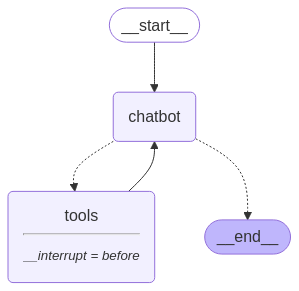

In [6]:
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"]
)

from IPython.display import Image, display

try:
    img = Image(graph.get_graph().draw_mermaid_png())
    display(img)
except Exception as e:
    print(f"Error displaying image: {e}")

In [8]:
config = {"configurable": {"thread_id": "1"}}
user_input = "오늘의 날씨를 검색해서 알려줘"

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

오늘의 날씨를 검색해서 알려줘
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_nhViPM80NxgLRAlBzK8DbK2p)
 Call ID: call_nhViPM80NxgLRAlBzK8DbK2p
  Args:
    query: 오늘의 날씨


In [9]:
snapshot = graph.get_state(config)
print(snapshot)
print(snapshot.next)

StateSnapshot(values={'messages': [HumanMessage(content='오늘의 날씨를 알려줘', additional_kwargs={}, response_metadata={}, id='3cb4cc1b-75fd-4c03-a88c-2be7e05e4292'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0ovpwwN91pC4fhyJ9CB9Y8L3', 'function': {'arguments': '{"query":"오늘의 날씨"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 86, 'total_tokens': 108, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9643ce32-ca2b-4afa-87a3-bc6dab70e986-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '오늘의 날씨'}, 'id': 'call_0ovpwwN91pC4fhyJ9CB9Y8L3', 'type': 'tool

In [11]:
existing_message = snapshot.values["messages"][-1]
print(existing_message.tool_calls)

[{'name': 'tavily_search_results_json', 'args': {'query': '오늘의 날씨'}, 'id': 'call_nhViPM80NxgLRAlBzK8DbK2p', 'type': 'tool_call'}]


In [12]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_nhViPM80NxgLRAlBzK8DbK2p)
 Call ID: call_nhViPM80NxgLRAlBzK8DbK2p
  Args:
    query: 오늘의 날씨
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "맨해튼, NY, 미국 일기예보 및 날씨 | Weather.com", "url": "https://weather.com/ko-KP/weather/today/l/Manhattan+NY+United+States?canonicalCityId=fc47c333c5d13e34e34c9fdb6e047ceb70f7891e01bc9e1d574b5f93f58aa76d", "content": "일별. 아침. 5°. 강수확률2% · 오후. 11°. 강수확률1% · 저녁. 9°. 강수확률4% · 밤새. 9°. 강수확률7%. 오늘 맨해튼, NY, 미국의 날씨 예보. 체감온도-1°. 06:24. 17:50.", "score": 0.4229103}, {"title": "뉴욕, NY 3일 날씨 예보 - AccuWeather", "url": "https://www.accuweather.com/ko/us/new-york/10021/weather-forecast/349727", "content": "뉴욕, NY 3일 날씨 예보 | AccuWeather 뉴욕 뉴욕 50° 오늘 WinterCast 지역 {stormName} 추적기 시간별 일별 레이더 MinuteCast 월 대기질 건강 및 활동 오늘 --시간별 일별 레이더 MinuteCast 월 대기질 건강 및 활동 현재 기상 ----- AM